# Testing regularization approaches

Here's a notebook for playing with different penalties

In [1]:
# %matplotlib notebook
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from matplotlib import pyplot as plt
from dement import DemEnt
import numpy as np
from scipy.optimize import minimize, check_grad
from scipy.special import erf
from scipy.special import expit

Initialize a model
--
We'll simulate a demographic history that suffers a crash then an exponential recovery

Define the time axis $\mathbf{t}$ (including the boundary at infinity) and the population size trajectory $\mathbf{y}$

In [2]:
t = np.array(list(np.arange(0, 1000, 4)) + [np.inf])

# constant
# y_true = 10000 * np.ones(len(t) - 1)

# crash followed by exponential growth
y_true = 100 * (4 * np.exp(-t[1:]/10) + 1 + 2 * np.array(t[1:] > 400, float))

# oscillatory
# y_true = 1000 * (10 * np.sin(-t[:-1]/100) * ((t[:-1] - t[-2]) / t[-2])**2 + 10)

# sigmoid crash at 50 generations ago
#y_true = 4000 * (- .95 * expit(-(t[1:] - 50) / 10) + 1) + 1000
#y_true = np.concatenate((y_true, [y_true[-1]]))

In [3]:
len(y_true)

250

The number of sampled haplotypes $n$:

In [4]:
n = 200

Initialize dement object, and print its docstring:


    A class that implements the model of Rosen et al., but adds a Poisson random
    field for generating the SFS from ξ
    


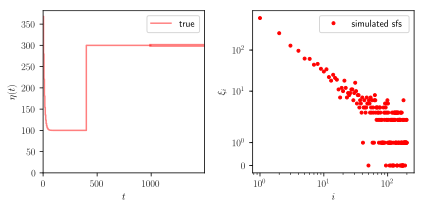

In [5]:
dement = DemEnt(n, t, y_true)
print(dement.__doc__)
dement.plot()

Inversion
--
### Initialization with constant model

We initialize by fitting a constant population size.
According to WSD's scribbles, the MLE assuming $\eta(t) = \eta_0$ (constant) is $\hat \eta_0 = \frac{S}{2 H_{n-1}}$, where $S$ is the number of segregating sites (the sum of the observed SFS vector) and $H_{n-1}$ is the $n$th harmonic number.
This was derived by using the well-known result (cited in Rosen et al.) that the expected SFS for a constant population is given by $\xi_i = \frac{2\eta_0}{i}$ (in units where $\eta$ is the population-scaled mutation rate).
Then the likelihood for $\eta_0$ is a Poisson random field parameterized by the $\xi_i$.

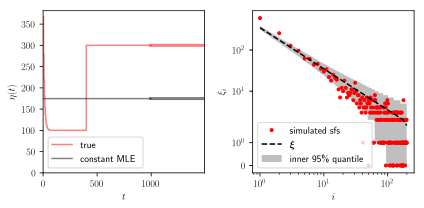

In [6]:
S = dement.sfs.sum()
H = (1 / np.arange(1, len(dement.sfs))).sum()
y_constant = (S / 2 / H) * np.ones(len(t) - 1)
dement.plot(y_constant, y_label='constant MLE')

### Regularized loss as a penalized log-likelihood
We must deal with the asymptotically constant boundary condition.
Standard regularizers blow up on the infinite epoch.
Let's use half Gaussian instead of Lebesgue measure on time to induce integrability: $\mathrm{d}\mu(t) = \frac{\sqrt{2}}{\sqrt{\pi}\tau}\exp\left(-\frac{1}{2}\left(\frac{t}{\tau}\right)^2\right)\mathrm{d}t,$
where $\tau$ is the characteristic time to asmptopia (the boundary of our time grid).
For example, a modified $L2$ would be
$$
R\left[\eta(t)\right] = \int_0^\infty \eta(t)^2 \mathrm{d}\mu(t) = \frac{\sqrt{2}}{\sqrt{\pi}\tau}\int_0^\infty \eta(t)^2 \exp\left(-\frac{1}{2}\left(\frac{t}{\tau}\right)^2\right)\mathrm{d}t.
$$
So the discretized problem is expressed in terms of the error function $\DeclareMathOperator{\erf}{erf}\erf(\cdot)$ if $\eta(t)$ is piecewise constant.
This will give extra (but finite) weight / penalty to the infinite epoch based on the survival function of $\mathrm{d}\mu(t)$.
We can tune how much weight the boundary epoch gets by tuning the width of the Gaussian.

In [7]:
def loss(y, y_prime, lambda_: float):
    # gaussian transformed measure
    #tau = 100 * dement.t[-2]
    #dmu = np.diff(erf(dement.t / tau / np.sqrt(2)))
    # generalized KL divergence (a Bregman divergence)
    #R_prior = ((y * np.log(y/y_prime) - y + y_prime) * dmu).sum()
    #R_prior = ((y - y_prime)**2 * dmu).sum()
    R_prior = ((y - y_prime)**2).sum()
    # L2 on derivative
    #R_diff = (np.diff(y)**2 * dmu[1:]).sum()
    y_diff = np.diff(y)
    weight = np.ones(len(y_diff))
    weight[-100:] = 1 + 10 * np.linspace(0, 1, 100)
    R_diff = ((weight * y_diff)**2).sum()
    return - dement.ell(y) + lambda_ * (0.001 * R_prior + R_diff)

### Minimize loss with L-BFGS-B

I'm using a constant L2 penalty to induce smoothness, and iterating a Bregman from a previous iterate's fit


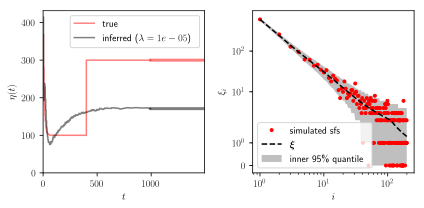

In [8]:
# Initial regularization strength
lambda_ = 1e-5

# initial and prior set to the constant population MLE
y = y_constant
y_prime = y_constant

#for _ in range(100):
result = minimize(loss,
                  y,
                  args=(y_prime, lambda_),
                  # jac=gradF,
                  method='L-BFGS-B',
                  options=dict(ftol=1e-5, maxfun=np.inf),
                  bounds=[(1, None)] * len(y))
assert result.success, result
y = result.x

dement.plot(y, y_label='inferred ($\lambda = {:.2g}$)'.format(lambda_))    

# update prior and reduce regularization strength
y_prime = y
lambda_ /= 2

In [9]:
y[-101:]

array([171.88038816, 171.90505567, 171.78920398, 172.11302446,
       171.95955758, 172.22196363, 171.72633196, 171.31191356,
       171.8383178 , 172.82226678, 173.31022815, 173.09992309,
       172.87718318, 173.2255147 , 173.35469291, 173.50545781,
       173.22904436, 172.68997851, 172.23683361, 172.42963177,
       172.20767491, 172.56449478, 172.31839922, 172.23139821,
       171.61004227, 171.35228787, 171.35995167, 171.25390036,
       170.52583349, 169.90145002, 169.93420421, 170.29585884,
       170.59116549, 170.6155337 , 170.66943943, 171.01271057,
       171.43703994, 171.75117621, 172.00943024, 172.14587247,
       172.33215517, 172.64440853, 173.07232563, 173.28020479,
       173.35814895, 173.43924286, 173.55639632, 173.64510707,
       173.56537278, 173.27999797, 172.95920024, 172.76609709,
       172.79421249, 172.94726067, 172.94193671, 172.79976962,
       172.64925855, 172.61359461, 172.77190321, 173.0200895 ,
       173.23445613, 173.37319515, 173.4852999 , 173.56

### Cray idea

Thm (8) of Rosen et al. tells us that we can always find a piecewise MLE.
But we're interested in finding smooth solutions that have the same likelihood as that piecewise MLE.
Can we penalize on the value of the MLE—in particular that it equals the optimal piecewise constant one—to learn about the structure of the inverse image?